In [496]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.signal as signal
import scipy.ndimage as image
import scipy.sparse as sparse
from tqdm import tqdm

In [636]:
n = 10
img = 0.8 + 0.2 * np.random.uniform(size=(n, n))
img[np.tril_indices_from(img)] -= 0.8

In [816]:
img = mpimg.imread("pictures/horse.png")[:, :, 0] * 0.99

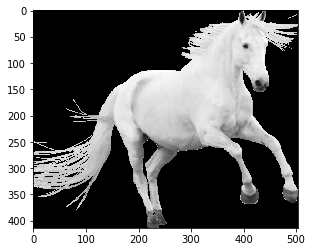

In [817]:
plt.imshow(img, cmap="Greys_r")

In [818]:
dim_img = img.shape
dim_grid = (10, 10, 6)

In [819]:
pixel_indices = np.arange(np.prod(dim_img)).reshape(dim_img).astype(int)
vertex_indices = np.arange(np.prod(dim_grid)).reshape(dim_grid).astype(int)

In [820]:
def neighbors(x_grid, y_grid, val_grid, dim_grid):
    all_neighbors = np.array([
        x_grid, y_grid, val_grid
    ]) + np.array([
        [0, 0, 1],
        [0, 0, -1],
        [0, 1, 0],
        [0, -1, 0],
        [1, 0, 0],
        [-1, 0, 0]
    ])
    feasible_neighbors = all_neighbors[
        (all_neighbors[:, 0] >= 0) & 
        (all_neighbors[:, 0] < dim_grid[0]) &
        (all_neighbors[:, 1] >= 0) & 
        (all_neighbors[:, 1] < dim_grid[1]) &
        (all_neighbors[:, 2] >= 0) & 
        (all_neighbors[:, 2] < dim_grid[2]) 
    ]
    return feasible_neighbors

In [821]:
x_img = np.indices(dim_img)[0].flatten()
y_img = np.indices(dim_img)[1].flatten()
val_img = img[x_img, y_img]

x_grid = np.rint((x_img / dim_img[0]) * (dim_grid[0] - 1)).astype(int)
y_grid = np.rint((y_img / dim_img[1]) * (dim_grid[1] - 1)).astype(int)
val_grid = np.rint(val_img * (dim_grid[2] - 1)).astype(int)

In [822]:
nearest_neighbors = vertex_indices[x_grid, y_grid, val_grid]

useful_vertices = np.sort(np.unique(nearest_neighbors))

In [823]:
S = sparse.lil_matrix((len(useful_vertices), np.prod(dim_img)), dtype=np.float)

for uv_ind, uv in enumerate(useful_vertices):
    nearby_pixels = np.where(nearest_neighbors == uv)[0]
    S[uv_ind, nearby_pixels] = 1

In [824]:
all_x_grid = np.indices(dim_grid)[0].flatten()
all_y_grid = np.indices(dim_grid)[1].flatten()
all_val_grid = np.indices(dim_grid)[2].flatten()

In [825]:
B = sparse.dok_matrix((np.prod(dim_grid), np.prod(dim_grid)), dtype=np.float)

for x_grid in range(dim_grid[0]):
    for y_grid in range(dim_grid[1]):
        for val_grid in range(dim_grid[2]):
            v_ind = vertex_indices[x_grid, y_grid, val_grid]
            
            B[v_ind, v_ind] = 6
            for neighbor_vertex in neighbors(x_grid, y_grid, val_grid, dim_grid):
                nb_ind = vertex_indices[tuple(neighbor_vertex)]
                B[v_ind, nb_ind] = 1
                
B = B.tolil()
B = B[np.ix_(useful_vertices, useful_vertices)]

In [826]:
def bistochastize(S, B):
    m = S.dot(np.ones(S.shape[1]))
    n = np.ones(B.shape[1])
    for it in range(50):
        new_n = np.sqrt((n * m) / (B.dot(n)))
        if np.linalg.norm(new_n - n) < 1e-5:
            break
        else:
            n = new_n
    Dn = sparse.csc_matrix(np.diag(n))
    Dm = sparse.csc_matrix(np.diag(m))
    return Dn, Dm

In [827]:
Dn, Dm = bistochastize(S, B)

In [828]:
c = np.ones(np.prod(dim_img))
t = img.flatten()

In [829]:
lambd = 10
AA = lambd * (Dm - Dn.dot(B).dot(Dn)) + np.diag(S.dot(c))
BB = S.dot(c * t)
CC = 0.5 * (c * t).dot(t)

In [830]:
def M_jacobi(y, A):
    return y / np.diagonal(A)

y_flat = S.dot(c * t) / S.dot(c)

In [831]:
def prec_conj_grad(y_init, A, b, M_1):
    y = y_init
    r = b - A.dot(y)
    d = M_1(r, A)
    lambd_new = np.float(r.dot(d.T))
    for it in range(50):
        q = A.dot(d.T)
        alpha = np.float(lambd_new / d.dot(q))
        y = y + alpha * d
        r = r - alpha * q.T
        s = M_1(r, A)
        lambd_old = lambd_new
        lambd_new = r.dot(s.T)
        beta = lambd_new / lambd_old
        d = s + beta * d
    return y.T

In [835]:
# y = prec_conj_grad(y_flat, AA, BB, M_jacobi)
y = sparse.linalg.lsqr(AA, BB)[0]

In [836]:
x = S.T.dot(y).reshape(img.shape)

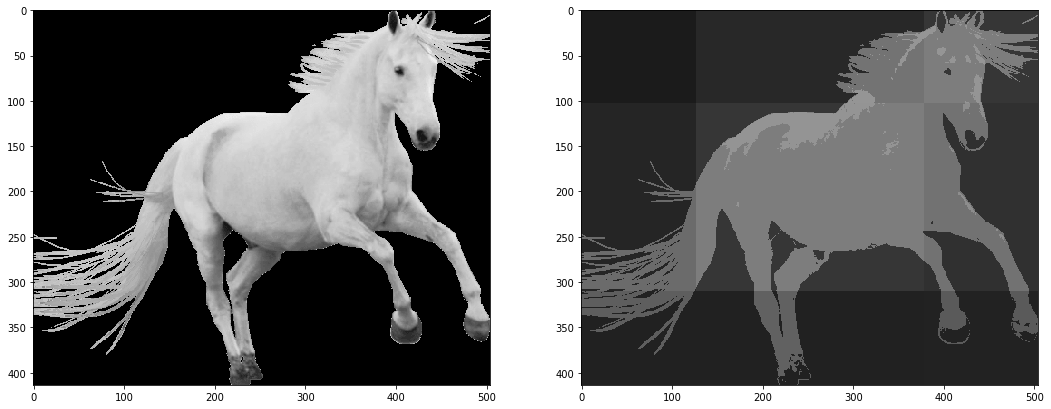

In [837]:
fig, ax = plt.subplots(1, 2, figsize=(18, 9))
ax[0].imshow(img, cmap="Greys_r", vmin=0, vmax=1)
ax[1].imshow(x, cmap="Greys_r", vmin=0, vmax=1)
plt.show()